# Short Time Fourier Transform(STFT)

## The Forward Transform

To obtain STFT of an audio:

1. Segment the signal into frames with ```dft_size``` samples and each frame will start ```hop_size``` samples after the beginning of the previous one. Pad the head/tail of the input if necessary.
2. Compute the Discrete Fourier Transform (DFT) of each frame. As a result, we will obtain a complex-valued 2D matrix ```S``` where ```S(i,j)``` is the coefficient for frequency ```i``` at input frame ```j```.
3. Apply an analysis window with the same length as ```dft_size``` to each frame in order to smoothly taper down to zero. Such window function can be the Hann window, the Hamming window, or the Kaizer window.
4. Optionally we can zero-pad each frame. Doing so will allow us to obtain smoother looking outputs when ```dft_size``` is small because zero padding in the time domain results in interpolation in the frequency domain. 

In [1]:
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
import os

In [2]:
def sound( x, rate=8000, label=''):
    """
        Make a sound player function that plays array "x" with a sample rate "rate", and labels it with "label"
    """
    from IPython.display import display, Audio, HTML
    if label == '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))
        
def stft(input_sound, dft_size=1024, hop_size=256, zero_pad=0, window='hanning'):
    """
        Given an input audio, return its STFT matrix
    """
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
        
    # number of frames = floot((input_length - dft_size) / hop_size)
    L = len(input_sound)
    num_frame = (L-dft_size)//hop_size
    tail = L-(num_frame*hop_size+dft_size)
    
    # pad input if necessary
    if tail>0:
        pad = hop_size-tail
        input_sound = np.pad(input_sound, (0,pad), 'constant')
        num_frame += 1
        
    # compute STFT coefficients
    S = np.zeros((num_frame, int((dft_size+zero_pad)/2)+1)).astype(complex)
    for i, t in enumerate(S[:]):
        input_f = input_sound[i*hop_size:i*hop_size+dft_size].astype(float)
        input_f *= w(len(input_f))
        input_f = np.pad(input_f, (0, zero_pad), 'constant')    
        S[i] = np.fft.rfft(input_f)
    S = S.T
    
    # return STFT and padded input
    return S, input_sound

def plot_spectrogram(fname, dft_size, hop_size, zero_pad, window):
    """
        Helper function for plotting STFT
    """
    sr, input_sound = wavfile.read(fname)
    input_sound = input_sound / np.max(input_sound)
    S, input_sound = stft(input_sound, dft_size, hop_size, zero_pad, window)
    t = np.linspace(0, len(input_sound)/sr, S.shape[1])
    f = np.linspace(0, int(sr/2), S.shape[0])
    plt.pcolormesh(t, f, np.log10(abs(S)+1e-5), shading='auto')
    title = os.path.splitext(fname)[0]
    plt.title(title.capitalize()+' Spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    return sr, input_sound, S

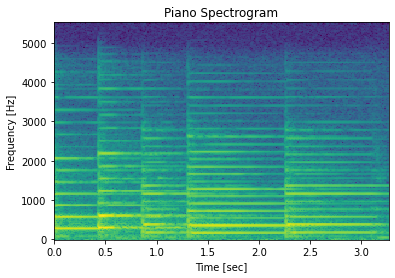

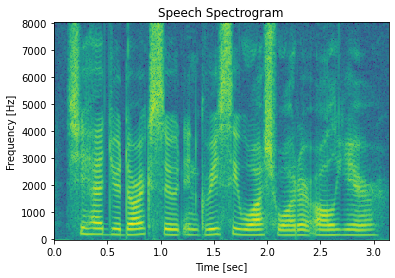

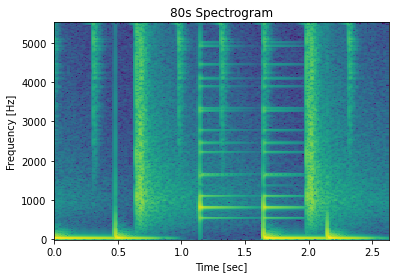

Piano


Speech


80s


In [3]:
sr, piano, piano_stft = plot_spectrogram('piano.wav', 512, 128, 0, 'hanning')
sr, speech, speech_stft = plot_spectrogram('speech.wav', 512, 128, 0, 'hanning')
sr, eighties, eighties_stft = plot_spectrogram('80s.wav', 512, 128, 0, 'hanning')
sound( piano, sr, 'Piano')
sound( speech, sr, 'Speech')
sound( eighties, sr, '80s')

## The Inverse Transform(ISTFT)

1. For each frame of the STFT matrix, take the inverse DFT.

2. After the IDFT operation, each frame is now a short segment of the original input. Reconstruct the input by overlap-adding these frames so that consecutive frames are offset by the same ```hop_size``` when getting the STFT. For the COLA principle to hold, we need to multiply each frame by a weighted synthesis window such that the square of the windows sum to one because we apply the window twice(analysis in STFT and synthesis and ISTFT).

In [4]:
def istft( stft_output, dft_size, hop_size, zero_pad, window):
    """
        Given an STFT, return the original audio
    """
    assert dft_size >= hop_size, "DFT size should be larger than hop size."
    if window=='hanning':
        w = np.hanning
    elif window=='hamming':
        w = np.hamming
    elif window=='kaiser':
        w = np.kaiser
    else:
        raise "Unsupported window type. Window should be either 'hanning', 'hamming' or 'kaiser'."
    
    # determine the length of the input audio
    T = stft_output.shape[1]
    L = hop_size*T+dft_size+zero_pad
    x = np.zeros(L)
    
    # inverse the STFT to get the input
    for t in range(T):
        curr_frame = stft_output[:, t]
        ifft = np.fft.irfft(curr_frame)
        ifft *= w(len(ifft)) * 0.7
        idx = t*hop_size
        x[idx:idx+dft_size+zero_pad] += ifft
    return x

def plot_input_and_istft(fname, input_sound, stft_output, dft_size, hop_size, zero_pad, window):
    """
        Helper function for plotting the input, ISTFT, and the reconstructed error percentage
    """
    recon_input = istft(stft_output, dft_size, hop_size, zero_pad, window)
    err_percentage = np.abs((recon_input-input_sound)/(input_sound+1e-5))
    fname = fname.capitalize()
    plt.figure(figsize=(20, 4))
    plt.subplot(131)
    plt.title(fname+' Signal')
    plt.plot(input_sound)
    plt.ylabel('Magnitude')
    plt.xlabel('Time [sec]')
    plt.subplot(132)
    plt.title('Inverse STFT of '+fname+' Signal')
    plt.plot(input_sound)
    plt.ylabel('Magnitude')
    plt.xlabel('Time [sec]')
    plt.subplot(133)
    plt.title('Recontructed Error Percentage')
    plt.plot(err_percentage)
    plt.ylabel('Percentage(%)')
    plt.xlabel('Time [sec]')
    plt.show()
    return recon_input

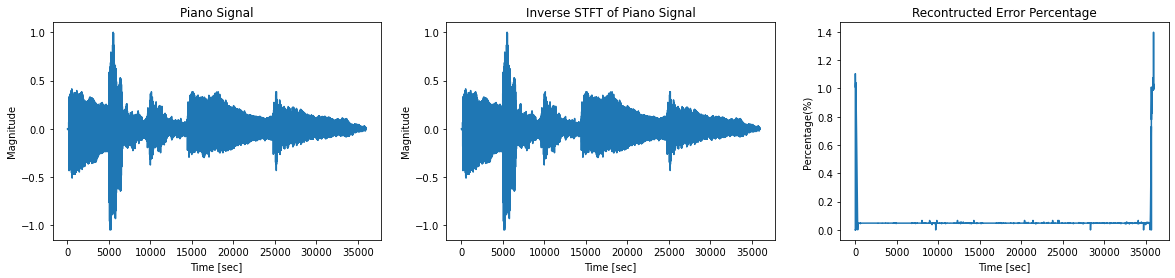

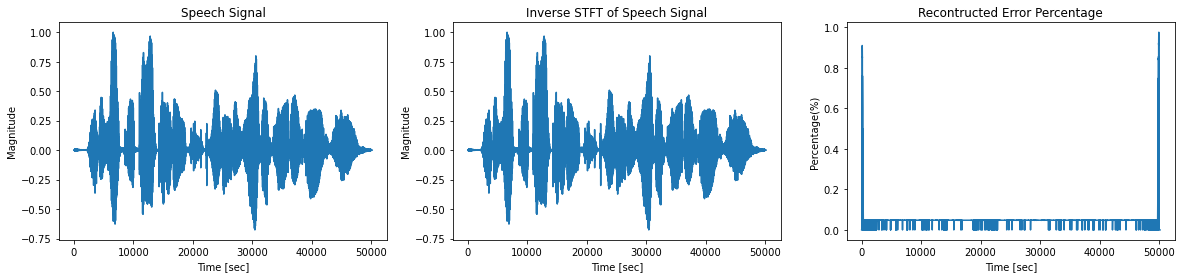

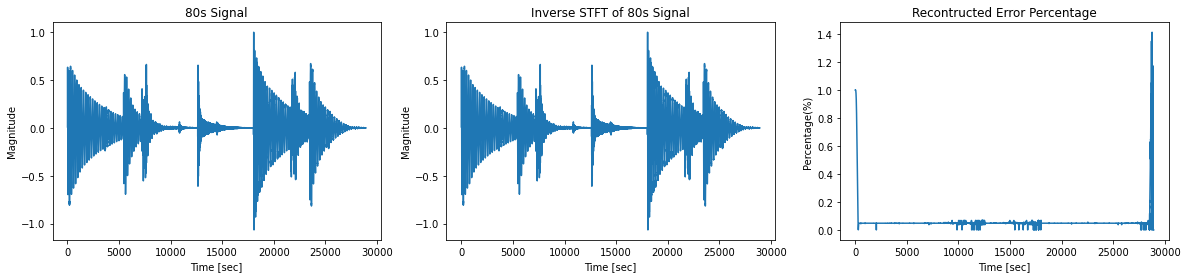

Reconstructed Piano


Reconstructed Speech


Reconstructed 80s


In [5]:
piano_istft = plot_input_and_istft('piano', piano, piano_stft, 512, 128, 0, 'hanning')
speech_istft = plot_input_and_istft('speech', speech, speech_stft, 512, 128, 0, 'hanning')
eighties_istft = plot_input_and_istft('80s', eighties, eighties_stft, 512, 128, 0, 'hanning')
sound( piano_istft, sr, 'Reconstructed Piano')
sound( speech_istft, sr, 'Reconstructed Speech')
sound( eighties_istft, sr, 'Reconstructed 80s')
wavfile.write('piano_recon.wav', sr, piano_istft)
wavfile.write('speech_recon.wav', sr, speech_istft)
wavfile.write('80s_recon.wav', sr, eighties_istft)